# State-averaged MCSCF

## CASCI response

As for truncated CI, the exact state response formulas also apply to CASCI and other active space CIs. The method can thus create all excited states that arise from excitations within the active space. This can also be used as an approximation for a MCSCF response, neglecting the orbital part of the response.

Let us try it on our usual water case. We'll use an active space including the 2 pairs of O-H $\sigma$ and $\sigma^*$ (4 electrons in 4 orbitals). However, since the main excitation also involves the oxygen lone pair, we add this orbital too, for a total CAS(6,5).

First, we try the intuitive concept of first optimizing the CASSCF wavefunction for the ground state, and then applying CASCI response with the 5 states.

In [1]:
import veloxchem as vlx
import multipsi as mtp

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
mol_str = """3

O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

molecule = vlx.Molecule.from_xyz_string(mol_str)
basis = vlx.MolecularBasis.read(molecule, "6-31g")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [3]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(mol_str, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(-90,'x')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
# CAS(6,5) calculation of water
space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.cas(6,5) #3 O_2p and 2 H_1s

# CASSCF calculation
mcscf_drv=mtp.McscfDriver()
mcscf_results = mcscf_drv.compute(molecule,basis,space)

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                                                          

          Active space def

In [5]:
nstates=5

# CASCI excitation energies
cidrv=mtp.CIDriver()
ci_results = cidrv.compute(molecule,basis,space,nstates)

# Transition properties
SI=mtp.InterState()
DipOsc=SI.compute(molecule, basis, ci_results)

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
         Solved by explicit diagonalization
                                                                                                                          
                                                                                                                          
        CI Iterations
        -------------
                  

In [6]:
# Results computed in CI response
FCI_excitation_energies=[8.44992, 10.68451, 10.97654, 13.37692]
CIS_excitation_energies=[9.38059, 11.30739, 11.83172, 13.90237]
au2ev = 27.211386

print("Full CI Energies")
print(FCI_excitation_energies)
print("CIS Energies")
print(CIS_excitation_energies)
print("CASCI Energies")
print(au2ev*DipOsc['energies'])

Full CI Energies
[8.44992, 10.68451, 10.97654, 13.37692]
CIS Energies
[9.38059, 11.30739, 11.83172, 13.90237]
CASCI Energies
[18.61974291 18.73087038 26.61579239 28.51654574]


As we can see, the result is very disappointing, very far from the full CI result, and even from the CIS result. The reason for that is the orbitals. The orbitals were optimized for the ground state, and not for the excited states. Like for truncated CI, we thus have an imbalance between the description of the ground and excited states leading to (significantly) too high excitation energies. In particular, in this case, the $\sigma^*$ orbitals are optimal to describe correlation in the O-H bonds, but not for the electronic excitation.

## State-specific optimization

A way to improve over the previous situation is to optimize every state separately with their own orbitals. This is called state-specific optimization. To ensure that we are doing an excited state, we still need to compute the ground states (or in general all states below the targeted state), but tell the program to optimize the orbitals specifically for the n_th state. In MultiPsi, this is done by providing "weights" (this concept will become more clear in the next section), a weight of 1 for the state of interest and 0 for all the other, meaning they will not influence the orbital optimization.

In [7]:
mcscf_results = mcscf_drv.compute(molecule,basis,space)
e0 = mcscf_drv.get_energy()

mcscf_results = mcscf_drv.compute(molecule,basis,space.copy(), n_states = 2 , weights = [0,1])
e1 = mcscf_drv.get_energy()

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                                                          

          Active space def

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
            Number of states      : 2
            State of interest     : 2
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                          

In [8]:
print(f"First state-specific MCSCF excitation energy = {(e1-e0)*au2ev:.4f}")
print(f"Corresponding (2nd) FCI excitation energy    = {FCI_excitation_energies[1]:.4f}")

First state-specific MCSCF excitation energy = 10.7588
Corresponding (2nd) FCI excitation energy    = 10.6845


As hoped, the first excitation energy is now a much better match to the FCI result. Actually, if we analyzed the orbitals, we would see that the state we converged is actually the second excited state, and the result is thus very close to the FCI result. We can also note that the second calculation still prints the ground state energy, but on the orbitals optimized for the excited state, and because of this, the energy of this state is higher than in the first calculation.

While in principle the most accurate description of the state that can be obtained at the MCSCF level, state-specific optimization has severe shortcomings hindering broader applicability. First, they way the calculation is done, the excited state is not necessarily orthogonal to the ground state, and it may therefore be artificially lower than it should. Second, if there is a small energy gap between states, the optimization may have trouble converging. We can see it if we try to optimize a second excited state:

In [9]:
mcscf_results = mcscf_drv.compute(molecule,basis,space.copy(), n_states = 3 , weights = [0,0,1])

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-specific calculation
            Number of states      : 3
            State of interest     : 3
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                          

The optimization oscillates as optimizing the second excited state brings its energy very close to the first, and thus the order of the states keep switching. While there exists "root following" techniques to overcome this, state-specific optimizations are usually fairly cumbersome.

For all these reasons, state-specific optimization is usually replaced by a so-called state-averaged optimization.

## State-averaging

Ideally, we would want each state to have its own orbitals while maintaining orthogonality betweem states. In the next chapter, we will see how this can be achieved within the framework of full MCSCF response. However, there is a way to improve the result without including the orbital response. The concept is to use only one orbital set for all states, but to make these orbitals a "compromise" between the needs of the ground state and that of the excited states. The description of each state would be worse but the hope is that this error would be consistent across all states and mostly cancel out in the excitation energies.

The way to do this is to construct a "state-average" MCSCF (SA-MCSCF), that is optimize the orbitals to minimize the average energy of all states. Doing this requires only a trivial modification of the code, namely the CI part of the MCSCF includes all states (here 5) and then the MCSCF energy is replaced by the average energy of all states and the CI densities are replaced by the average density of all states. Note that this is simply an extension of the state-specific optimization mentioned above, but using equal weights for all states.

Let's see it in practice:

In [10]:
# CASSCF calculation
# 5 states included already in the MCSCF.
mcscf_results = mcscf_drv.compute(molecule,basis,space,nstates)

# Transition properties
DipOsc=SI.compute(molecule, basis, mcscf_results)

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-averaged calculation
            Number of states      : 5
            Equal-weights 
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                     

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.55788         1.182610e-02    2.629897e-02
     1       4       10.32868         1.101141e-01    1.302112e-01
     1       5       12.56324         1.491877e-01    1.439100e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)


In [11]:
print("Full CI Energies")
print(FCI_excitation_energies)
print("CIS Energies")
print(CIS_excitation_energies)
print("SA-CASSCF Energies")
print(au2ev*DipOsc['energies'])

Full CI Energies
[8.44992, 10.68451, 10.97654, 13.37692]
CIS Energies
[9.38059, 11.30739, 11.83172, 13.90237]
SA-CASSCF Energies
[ 7.55787583  9.83566209 10.32868402 12.56323891]


The result is now significantly closer to the converged full CI result. In this particular case, the result is not better than CIS, but of course, one the main motivation to use MCSCF is for systems with strong correlation, which was not the case here.

This method is of course not without issues. In particular, unlike standard responses calculation, the introduction of state-averaging means that the excitation energies depend on the total number of states, since the state-averaged orbitals depend on all states. In particular, we can expect the results to deteriorate with increasing number of states as the orbitals begin to compromise many states of widely different natures:

In [12]:
first_exc_energy=[]
for nstates in range(2,6):
    
    # CASSCF calculation
    # 5 states included already in the MCSCF
    mcscf_results = mcscf_drv.compute(molecule,basis,space,nstates)

    # Transition properties
    DipOsc=SI.compute(molecule, basis, mcscf_results)
    
    first_exc_energy.append(au2ev*DipOsc['energies'][0])

                                                                                                                          
                          Multi-Configurational Self-Consistent Field Driver
                                                                                                                          
        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          State-averaged calculation
            Number of states      : 2
            Equal-weights 
          Max. iterations         : 50
          BFGS window             : 5
          Convergence thresholds:
            - Energy change       : 1e-08
            - Gradient norm       : 0.0001
                                                                                                                          
          Integrals in memory
                                                                                     

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        8.08803         8.153140e-03    3.791438e-02
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)
                                                                                                                          
                          Multi-Configurational Self-Consistent Field Drive

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.95275         8.899154e-03    4.003592e-02
     1       3       15.27448         3.502949e-01    3.169114e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)
                                                                                                                          
        

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.85494         7.812110e-03    4.149883e-02
     1       4       14.92669         4.583994e-01    3.096527e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)
                                                                                                                          
        

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        7.55790         1.182597e-02    2.629915e-02
     1       4       10.32870         1.101138e-01    1.302110e-01
     1       5       12.56326         1.491866e-01    1.439092e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)


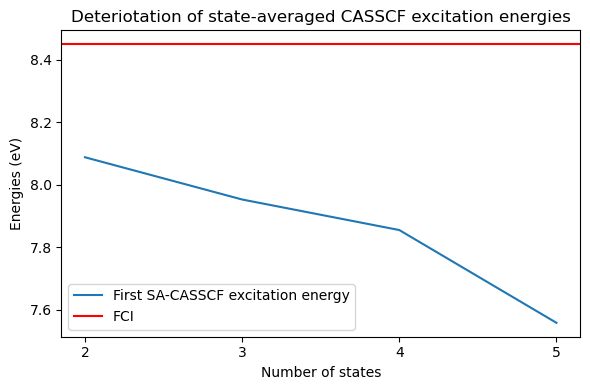

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
x = np.array(range(2,6))
plt.plot(x,np.array(first_exc_energy), label='First SA-CASSCF excitation energy')
plt.title('Deteriotation of state-averaged CASSCF excitation energies')
plt.ylabel("Energies (eV)")
plt.xlabel("Number of states")

plt.axhline(y=FCI_excitation_energies[0],label ='FCI',color='red')
plt.xticks(x)
plt.legend()
plt.tight_layout(); plt.show()

While for 2 states, the first excitation energy was relatively close to the fullCI, it degrades significantly as more states are added, with a difference of more than 0.5 eV going from 2 to 5 states. Adding dynamical correlation on-top of the CASSCF typically reduces this error, but it is still an undesirable behaviour.

Still, because of its simplicity and its reasonable accuracy, SA-MCSCF is one of the most frequently used technique to compute properties at the MCSCF level.